<a href="https://colab.research.google.com/github/sufyanAshraf/AI_Agents/blob/main/lang_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install langgraph langchain langchain_community langchain_huggingface langchain_groq

In [ ]:
from typing import Annotated, Literal, Sequence, TypedDict
from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.tools.retriever import create_retriever_tool
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

In [ ]:
from google.colab import userdata

userdata.get('HF_TOKEN')
userdata.get('LANGCHAIN_API_KEY')
GROQ_API_KEY = userdata.get('GROQ_API_KEY')


In [ ]:
from huggingface_hub import login

login("hf_") # add key

In [ ]:
from langchain_huggingface import HuggingFaceEmbeddings

In [ ]:
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

In [ ]:
from groq import Groq

In [ ]:
from langchain_groq import ChatGroq
llm=ChatGroq(groq_api_key=GROQ_API_KEY,
         model_name="mixtral-8x7b-32768")

In [ ]:
llm.invoke("hi hello how are you?")

AIMessage(content="Hello! I'm just a computer program,What can I help you with today?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 14, 'total_tokens': 33, 'completion_time': 0.028154118, 'prompt_time': 0.00239378, 'queue_time': 0.021775407000000004, 'total_time': 0.030547898}, 'model_name': 'mixtral-8x7b-32768', 'system_fingerprint': 'fp_c5f20b5bb1', 'finish_reason': 'stop', 'logprobs': None}, id='run-1ab11392-60c7-47de-b8f9-2356b3201a61-0', usage_metadata={'input_tokens': 14, 'output_tokens': 19, 'total_tokens': 33})

In [ ]:
url= "https://lilianweng.github.io/posts/2023-06-23-agent/"
WebBaseLoader(url).load()

In [ ]:
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
]

In [ ]:
docs = [WebBaseLoader(url).load() for url in urls]

In [ ]:
docs_list = [item for sublist in docs for item in sublist]

In [ ]:
pip install tiktoken

In [ ]:
text_splitter=RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=100, chunk_overlap=5)
doc_splits=text_splitter.split_documents(docs_list)


In [ ]:
pip install chromadb

In [ ]:
vectorstore=Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chrome",
    embedding=embeddings

)

In [ ]:
retriever=vectorstore.as_retriever()

In [ ]:
retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.You are a specialized assistant. Use the 'retriever_tool' **only** when the query explicitly relates to LangChain blog data. For all other queries, respond directly without using any tool. For simple queries like 'hi', 'hello', or 'how are you', provide a normal response.",

)

In [ ]:
tools=[retriever_tool]

In [ ]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [ ]:
def ai_assistant(state:AgentState):
    print("---CALL AGENT---")
    messages = state['messages']
    print(f"this is my message: {messages}")

    if len(messages)>1:
        response=llm.invoke(messages[-1].content)
        return {"messages": [response]}
    else:
        llm_with_tool = llm.bind_tools(tools)
        response = llm_with_tool.invoke(messages)
        #response=handle_query(messages)
        return {"messages": [response]}

In [ ]:
class grade(BaseModel):
    binary_score:str=Field(description="Relevance score 'yes' or 'no'")

In [ ]:
def grade_documents(state:AgentState)->Literal["Output_Generator", "Query_Rewriter"]:
    llm_with_structure_op=llm.with_structured_output(grade)

    prompt=PromptTemplate(
        template="""You are a grader deciding if a document is relevant to a user’s question.
                    Here is the document: {context}
                    Here is the user’s question: {question}
                    If the document talks about or contains information related to the user’s question, mark it as relevant.
                    Give a 'yes' or 'no' answer to show if the document is relevant to the question.""",
                    input_variables=["context", "question"]
                    )
    chain = prompt | llm_with_structure_op

    messages = state["messages"]
    print(f"message from the grader: {messages}")
    last_message = messages[-1]
    question = messages[0].content
    docs = last_message.content
    scored_result = chain.invoke({"question": question, "context": docs})
    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generator" #this should be a node name
    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        return "rewriter" #this should be a node name

In [ ]:
def generate(state:AgentState):
    print("---GENERATE---")
    messages = state["messages"]

    print(f"here is message from generate: {messages}")

    question = messages[0].content
    last_message = messages[-1]
    docs = last_message.content

    prompt = hub.pull("rlm/rag-prompt")

    rag_chain = prompt | llm

    response = rag_chain.invoke({"context": docs, "question": question})
    print(f"this is my response:{response}")

    return {"messages": [response]}

In [ ]:
from langchain_core.messages import  HumanMessage
def rewrite(state:AgentState):
    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    print(f"here is message from rewrite: {messages}")

    message = [HumanMessage(content=f"""Look at the input and try to reason about the underlying semantic intent or meaning.
                    Here is the initial question: {question}
                    Formulate an improved question: """)
       ]
    response = llm.invoke(message)
    return {"messages": [response]}

In [ ]:
workflow=StateGraph(AgentState)
workflow.add_node("My_AI_Assistant",ai_assistant)
retrieve = ToolNode([retriever_tool])
workflow.add_node("Vector_Retriever", retrieve)
workflow.add_node("Query_Rewriter", rewrite)
workflow.add_node("Output_Generator", generate)

In [ ]:
workflow.add_edge(START,"My_AI_Assistant")

In [ ]:
workflow.add_conditional_edges("My_AI_Assistant",
                               tools_condition,
                               {"tools": "Vector_Retriever",
                                END: END,})

In [ ]:
workflow.add_conditional_edges("Vector_Retriever",
                            grade_documents,
                            {"generator": "Output_Generator",
                            "rewriter": "Query_Rewriter"
                            })

In [ ]:
workflow.add_edge("Output_Generator", END)

In [ ]:
workflow.add_edge("Query_Rewriter", "My_AI_Assistant")

In [ ]:
app=workflow.compile()

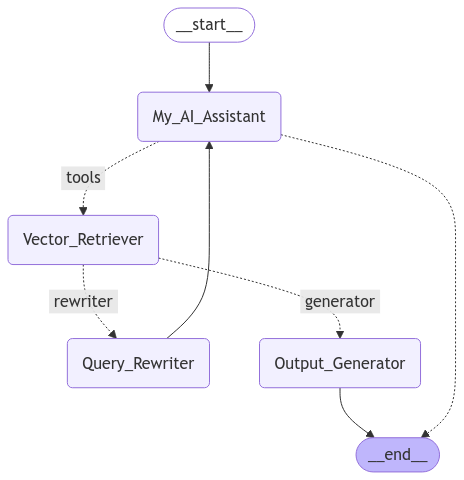

In [ ]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
app.invoke({"messages":["What is a Autonomous Agent?"]})

---CALL AGENT---
this is my message: [HumanMessage(content='What is a Autonomous Agent?', additional_kwargs={}, response_metadata={}, id='40474664-85a4-4bc3-b689-1786491a144c')]


{'messages': [HumanMessage(content='What is a Autonomous Agent?', additional_kwargs={}, response_metadata={}, id='40474664-85a4-4bc3-b689-1786491a144c'),
  AIMessage(content='An Autonomous Agent is a software entity that can independently make decisions and take actions to achieve its goals. It can perceive its environment through sensors, process information, and act upon the environment through effectors. Autonomous agents can operate in dynamic and complex environments, and can adapt to changes in the environment to fulfill their objectives. They are often used in applications such as robotics, artificial intelligence, and multi-agent systems.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 89, 'prompt_tokens': 1270, 'total_tokens': 1359, 'completion_time': 0.138440215, 'prompt_time': 0.114744912, 'queue_time': 0.067665103, 'total_time': 0.253185127}, 'model_name': 'mixtral-8x7b-32768', 'system_fingerprint': 'fp_c5f20b5bb1', 'finish_reason': 'stop', '

In [ ]:
app.invoke({"messages":["What is a prompt engineering?"]})

---CALL AGENT---
this is my message: [HumanMessage(content='What is a prompt engineering?', additional_kwargs={}, response_metadata={}, id='e2dcc5b1-99a5-41d5-982a-58e3579c0123')]


{'messages': [HumanMessage(content='What is a prompt engineering?', additional_kwargs={}, response_metadata={}, id='e2dcc5b1-99a5-41d5-982a-58e3579c0123'),
  AIMessage(content="Prompt engineering is the process of designing and optimizing the input given to a language model, such as a large language model (LLM), to generate desired outputs. It involves carefully crafting the prompt to guide the model in producing specific and useful responses. This can include providing context, examples, or instructions to help the model understand the task at hand. Prompt engineering is an important skill for effectively using language models, as the quality of the prompt can significantly impact the quality of the model's output.", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 104, 'prompt_tokens': 1268, 'total_tokens': 1372, 'completion_time': 0.160009316, 'prompt_time': 0.117495438, 'queue_time': 0.020529384999999997, 'total_time': 0.277504754}, 'model_name': 'mixtr